# Определение перспективного тарифа для телекомкомпании
Пользователям предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## План анализа:

- Загрузить таблицы
- Провести анализ этих таблиц, определить проблемы с данными.
- Провести предобработку данных
- Поменять типы данных
- Согласно условиям оператора округляем время звонков и интернета за большего целого
- Добавить столбец с месяцем, когда производился звонок, отправлялась смс и был выход в интернет
- Формируем единую таблицу по месяцам и звонков, интернета и смс
- Пишем функцию, которая считаем прибыль по месяцам
- Формируем таблицы с тарифами
- Считаем дисперсию, стандартное отклонение, среднее по каждому показателю
- Строим графики зависимости двух тарифов по всем показателям
- Анализ графиков
- Строим гипотезу различия двух тарифов
- Строим гипотезу различия среднего в Москве и в других районах
- Итоговый вывод

## Общая информация о данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns
import math
pd.set_option('display.max_columns', None)

In [2]:
# прочитаем файлы:

data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')
data_calls = pd.read_csv('/datasets/calls.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_internet = pd.read_csv('/datasets/internet.csv')

Поверхностно изучим данные таблиц.

In [3]:
# небольшая функция, которой обычно пользуюсь...
def df_info(df_name):
    display(df_name.head())
    display(df_name.info())
    display(df_name.duplicated().sum())

In [4]:
df_info(data_tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

0

`Data_tariffs` - это база с информацией о тарифах. Состоит из 8 столбцов и 2 строк. Пропущенных значений нет.

In [5]:
df_info(data_users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

0

`Data_users` - это база с информацией о пользователях. Состоит из 8 столбцов и 500 строк. Пропущенные значения есть. У столбца churn_date есть 462 пропуска.Это столбец с датой прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). В полследствии можно заменить на 0.

In [6]:
df_info(data_calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

0

`Data_call` - это база с звонками всех пользователей. Состоит из 4 столбцов и 202607 строк. Пропущенных значений нет.

In [7]:
df_info(data_messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

0

`Data_messages` - это база с использованными сообщениями всех пользователей. Состоит из 3 столбцов и 123036 строк. Пропущенных значений нет.

In [8]:
df_info(data_internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

0

`Data_internet` - это база с звонками всех пользователей. Состоит из 4 столбцов и 149396 строк. Пропущенных значений нет.

**Вывод:**

Есть проблемы в данных. Надо менять типы данных в бд. Присутствуют пропуски в churn_date. Возможно, есть смысл их просто поменять на 0(значит смены оператора не было). Ничего необычного.

## Предобработка данных
Во всех столбцах где есть дата меняем тип на date_time

In [9]:
# в data_tariffs все в порядке
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'],format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

В таблице df_internet есть столбец `Unnamed: 0`, который повторяет индексы строк. Его можно удалить.

In [10]:
del data_internet['Unnamed: 0']

### Вычисление параметров для каждого пользователя

Начнем с того, что добавим к каждой таблице колонку month, в которой будет отображен месяц совершения действия, чтобы потом можно было группировать по месяцам.

In [40]:
# список с таблицами где есть числовые значения
list_tables = [data_tariffs, data_users, data_calls, data_messages, data_internet]

# определим переменную как список, в которм будет хранится название таблицы и колонки в ней, содержащей дату совершения действия
date_list = []

# нам нужны только три столбца со звонками, сообщениями и трафиком
# поэтому начинаем двигаться со второго индекса в списке таблиц
for i in range(2, len(list_tables)):
    
    # в списке колонок таблицы будем искать ту, у которой название заканчивается на 'date'
    # методом включения определенных символов в срез строки
    for j in range(0, len(list_tables[i].columns)):
        if 'date' in list_tables[i].columns[j][-4:]:
            date_list.append(list_tables[i].columns[j])
            
    # с помощью метода dt.month добавляем месяц в новую колонку 'month'
    list_tables[i]['month'] = list_tables[i][date_list[i-2]].dt.month

#### Количество сделанных звонков и израсходованных минут разговора по месяцам:

In [13]:
def ceil_value(value):
    return math.ceil(value)
data_calls['duration'] = data_calls['duration'].apply(ceil_value)


data_calls_pivot = data_calls.pivot_table(index=['user_id', 'month'], aggfunc={'call_date':'count', 'duration':sum}) 
data_calls_pivot.columns = ['calls_count', 'calls_duration']
data_calls_pivot.head()

calls_count  calls_duration
user_id month                             
1000    5               22             159
        6               43             172
        7               47             340
        8               52             408
        9               58             466

#### Количество отправленных сообщений по месяцам:

In [14]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], aggfunc={'id':'count'})
data_messages_pivot.columns = ['messages_count']
data_messages_pivot.head()

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

#### Объем израсходованного интернет-трафика по месяцам:

In [15]:
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'], aggfunc={'mb_used':sum})
data_internet_pivot.columns = ['traffic_volume']
data_internet_pivot.head()

traffic_volume
user_id month                
1000    5             2253.49
        6            23233.77
        7            14003.64
        8            14055.93
        9            14568.91

Объеденим все имеющиеся таблицы.

In [16]:
pre_data = data_internet_pivot.join([data_calls_pivot, data_messages_pivot]).reset_index(level='month')
pre_data.head()

,month,traffic_volume,calls_count,calls_duration,messages_count
user_id,,,,,
1000,5,2253.49,22.0,159.0,22.0
1000,6,23233.77,43.0,172.0,60.0
1000,7,14003.64,47.0,340.0,75.0
1000,8,14055.93,52.0,408.0,81.0
1000,9,14568.91,58.0,466.0,57.0


Для дальнейшего рассчета помесячной выручки, объеденим все сводные таблицы и таблицу data_users.

In [17]:
data = data_users.join(pre_data, on='user_id')
data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,traffic_volume,calls_count,calls_duration,messages_count
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,2253.49,22.0,159.0,22.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23233.77,43.0,172.0,60.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,14003.64,47.0,340.0,75.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,14055.93,52.0,408.0,81.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,14568.91,58.0,466.0,57.0


Удалим те столбцы, с которыми мы точно работать не будем. 

In [18]:
del data['churn_date']
del data['first_name']
del data['last_name']
del data['reg_date']

Округлим значения трафика в мб, и добавим столбец с трафиком в гб.

In [19]:
data['traffic_volume'] = np.ceil(data['traffic_volume'])

data['traffic_volume_gb'] = np.ceil(data['traffic_volume'] / 1024 )
data.head(10)

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,traffic_volume_gb
0,1000,52,Краснодар,ultra,5.0,2254.0,22.0,159.0,22.0,3.0
0,1000,52,Краснодар,ultra,6.0,23234.0,43.0,172.0,60.0,23.0
0,1000,52,Краснодар,ultra,7.0,14004.0,47.0,340.0,75.0,14.0
0,1000,52,Краснодар,ultra,8.0,14056.0,52.0,408.0,81.0,14.0
0,1000,52,Краснодар,ultra,9.0,14569.0,58.0,466.0,57.0,15.0
0,1000,52,Краснодар,ultra,10.0,14703.0,57.0,350.0,73.0,15.0
0,1000,52,Краснодар,ultra,11.0,14757.0,43.0,338.0,58.0,15.0
0,1000,52,Краснодар,ultra,12.0,9818.0,46.0,333.0,70.0,10.0
1,1001,41,Москва,smart,11.0,18430.0,59.0,430.0,NaN,18.0
1,1001,41,Москва,smart,12.0,14037.0,63.0,414.0,NaN,14.0


#### Помесячная выручка с каждого пользователя:

Добавим к df_cmiu_pivot информацию о тарифах из таблицы data_tariffs, для этого сначала поменяем название нужного столбца на tariff


In [20]:
data_tariffs = data_tariffs.rename(columns={'tariff_name':'tariff'})
data = data.merge(data_tariffs, on='tariff')
data

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,traffic_volume_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,5.0,2254.0,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1
1,1000,52,Краснодар,ultra,6.0,23234.0,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1
2,1000,52,Краснодар,ultra,7.0,14004.0,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1
3,1000,52,Краснодар,ultra,8.0,14056.0,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1
4,1000,52,Краснодар,ultra,9.0,14569.0,58.0,466.0,57.0,15.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,1498,68,Владикавказ,smart,10.0,20580.0,41.0,247.0,42.0,21.0,50,15360,500,550,200,3,3
3202,1499,35,Пермь,smart,9.0,1846.0,9.0,70.0,11.0,2.0,50,15360,500,550,200,3,3
3203,1499,35,Пермь,smart,10.0,17789.0,68.0,449.0,48.0,18.0,50,15360,500,550,200,3,3
3204,1499,35,Пермь,smart,11.0,17964.0,74.0,612.0,59.0,18.0,50,15360,500,550,200,3,3


После объединения таблиц образовалось немало пропусков, особенно в messages_count. Это произошло из-за разницы в исходных данных. Оставить как есть или отбросить их не вариант, т.к. в первом случае они повляют на дальнейшие расчеты, а во втором потеряем много данных. Поэтому заменим все пропуски на ноль.

In [21]:
data.isnull().sum()

user_id                    0
age                        0
city                       0
tariff                     0
month                      3
traffic_volume             3
calls_count               43
calls_duration            43
messages_count           500
traffic_volume_gb          3
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [22]:
# пропуски в колонке month заменить на ноль нельзя, всего три строки с пропусками, поэтому удалим их
data = data.dropna(subset=['month'])

# остальные пропуски заменим на ноль
data = data.fillna(0)

In [23]:
data.isnull().sum()

user_id                  0
age                      0
city                     0
tariff                   0
month                    0
traffic_volume           0
calls_count              0
calls_duration           0
messages_count           0
traffic_volume_gb        0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

Рассчитаем помесячную выручку при помощи функции money.

In [24]:
def money(row):
    
# определим переменные
    
    bill_minutes = 0
    bill_sms = 0
    bill_traffic = 0


# проверим разницу между суммарными значениями звонков, сообщений, трафика и бесплатным лимитом тарифа
# если эта разница меньше нуля, то возвращаем ноль - клиент не израсходовал бесплатный лимит
# если больше - то разницу умножаем на стоимость сверх тарифного плана
    
    if row['calls_duration'] > row['minutes_included']:
        bill_minutes += (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    if row['calls_duration'] < row['minutes_included']:
        bill_minutes = 0
    if row['messages_count'] > row['messages_included']:
        bill_sms += (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    if row['messages_count'] < row['messages_included']:
        bill_sms = 0
    if row['traffic_volume'] > row['mb_per_month_included']:
        bill_traffic += (np.ceil((row['traffic_volume'] - row['mb_per_month_included']) / 1024 )) * row['rub_per_gb']# округляем мегабайты вверх до гигабайт
    if row['traffic_volume'] < row['mb_per_month_included']:
        bill_traffic = 0
        
# функция возвращает итоговый счет за месяц для клиента,
# в котором к сумме счетов за отдельные категории услуг прибавляется абонентская плата за тариф
        
    return bill_minutes + bill_sms + bill_traffic + row['rub_monthly_fee']

In [25]:
data['total_bill']=data.apply(money,axis=1) 
data

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,traffic_volume_gb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total_bill
0,1000,52,Краснодар,ultra,5.0,2254.0,22.0,159.0,22.0,3.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,Краснодар,ultra,6.0,23234.0,43.0,172.0,60.0,23.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,Краснодар,ultra,7.0,14004.0,47.0,340.0,75.0,14.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,Краснодар,ultra,8.0,14056.0,52.0,408.0,81.0,14.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,Краснодар,ultra,9.0,14569.0,58.0,466.0,57.0,15.0,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,1498,68,Владикавказ,smart,10.0,20580.0,41.0,247.0,42.0,21.0,50,15360,500,550,200,3,3,1750.0
3202,1499,35,Пермь,smart,9.0,1846.0,9.0,70.0,11.0,2.0,50,15360,500,550,200,3,3,550.0
3203,1499,35,Пермь,smart,10.0,17789.0,68.0,449.0,48.0,18.0,50,15360,500,550,200,3,3,1150.0
3204,1499,35,Пермь,smart,11.0,17964.0,74.0,612.0,59.0,18.0,50,15360,500,550,200,3,3,1513.0


**Вывод:**

Посчитали для каждого пользователя количество сделанных звонков и израсходованных минут, количество отправленных сообщений и объем израсходованного интернет-трафика по месяцам, а так же помесячную выручку с каждого пользователя

## Анализ

Чтобы посмотреть поведение клиентов посчитаем помесячную сумму исследуемых параметров для всех пользователей:

In [29]:
df_month_sum = (data
                .pivot_table(index=['tariff', 'month'],
                             values=['calls_count', 'calls_duration', 'messages_count', 'traffic_volume_gb', 'total_bill'],
                             aggfunc=sum))

df_month_sum = df_month_sum.reset_index(level='month')
df_month_sum

,month,calls_count,calls_duration,messages_count,total_bill,traffic_volume_gb
tariff,,,,,,
smart,1.0,941.0,6931.0,620.0,24525.0,297.0
smart,2.0,2331.0,17324.0,1397.0,48001.0,687.0
smart,3.0,4183.0,30034.0,2453.0,89676.0,1173.0
smart,4.0,5747.0,41119.0,3443.0,107866.0,1526.0
smart,5.0,7789.0,54618.0,4762.0,168849.0,2243.0
smart,6.0,9110.0,64885.0,5478.0,197459.0,2616.0
smart,7.0,11402.0,82079.0,6784.0,246014.0,3191.0
smart,8.0,13856.0,98995.0,7904.0,309790.0,3933.0
smart,9.0,15482.0,111439.0,8746.0,324986.0,4262.0


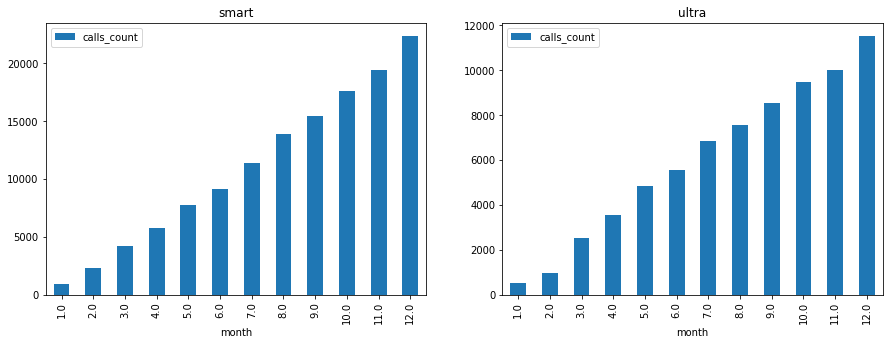

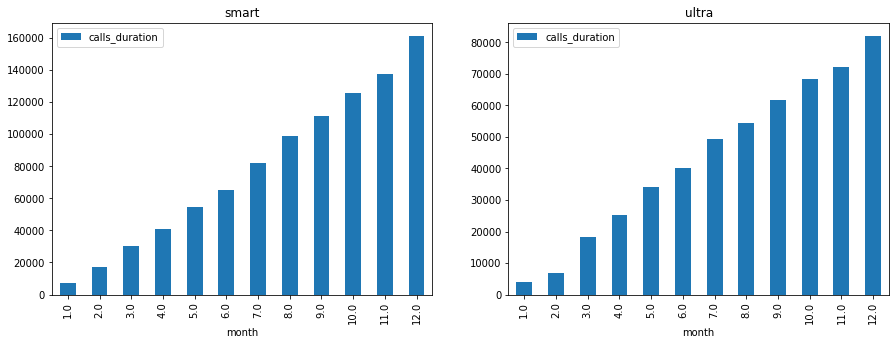

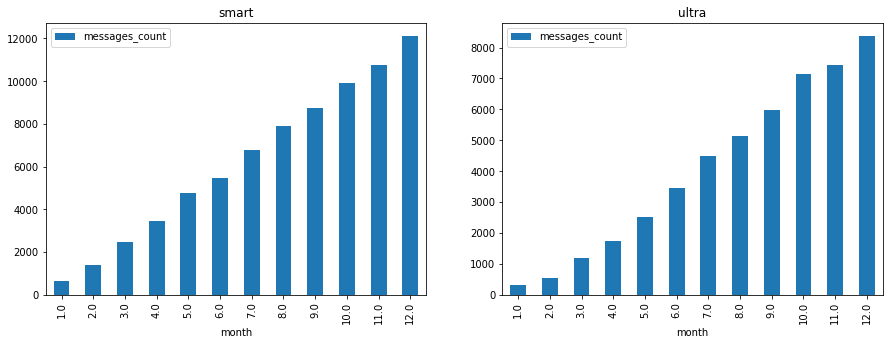

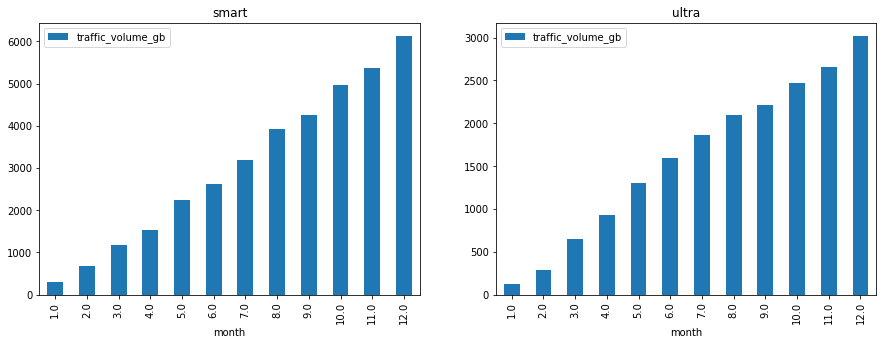

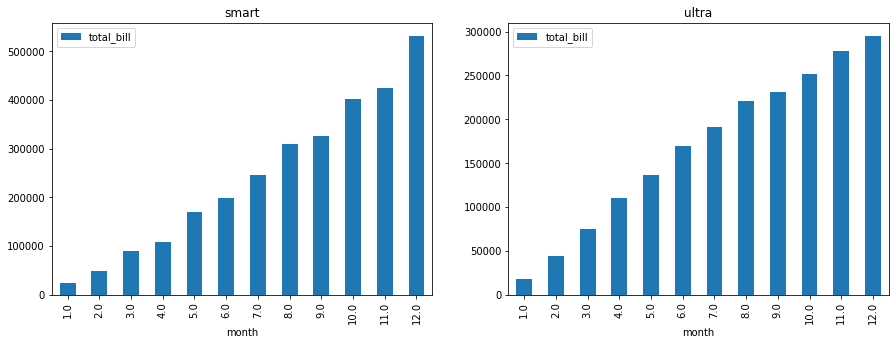

In [30]:
# для большей наглядности построим столбчатые графики распределения суммарных значений параметров в течение года:

for dms_col_name in ['calls_count', 'calls_duration', 'messages_count', 'traffic_volume_gb', 'total_bill']:
    fig, axs = plt.subplots(1,2)
    df_month_sum[df_month_sum.index=='smart'].plot(x='month', y=dms_col_name, kind='bar', title='smart', ax=axs[0], figsize=(15, 5))
    df_month_sum[df_month_sum.index=='ultra'].plot(x='month', y=dms_col_name, kind='bar', title='ultra', ax=axs[1], figsize=(15, 5))

На количественные показатели здесь можно не смотреть, т.к. объем выборок разный:

In [31]:
data[data['tariff']=='smart']['tariff'].count()

2228

In [32]:
data[data['tariff']=='ultra']['tariff'].count()

975

А вот поведение клиентов в течение рассматриваемого периода времени графики показывают очень хорошо:
как видим все параметры (количество звонков, продолжительность разговоров, количество сообщений, объем израсходованного интернет-трафика и ежемесячный счет) растут о января к декабрю, причем растут довольно таки линейно и не зависимо от того, какой тариф используют клиенты.
Январь и декабрь еще могу объяснить - в январе много отдыхают семьями и не до звонков, а в декабре все аврально завершают дела и поздравляют близких. Постепенный и устойчивый рост между этими двумя месяцами объяснить не могу.

Посчитаем среднее, дисперсию и стандартное отклонение для всех пользователей в течение всего периода:

Применим цикл, в котором с помощью сводных таблиц раассчитаем необходимые параметры.

In [33]:
for i in range(0, 3):
    functions = ['mean', np.var, np.std]# функции, которые будем применять к значениям
    tables = ['total_month_sum_mean', 'total_month_sum_var', 'total_month_sum_std']# названия сводных таблиц
    list_of_cols = ['calls_duration', 'messages_count', 'traffic_volume_gb', 'total_bill']# значения
    suffix = ['_mean', '_var', '_std']# суффикс, который добавим к именам колонок
    
    tables[i] = data.pivot_table(index=['tariff'], values=list_of_cols, aggfunc=functions[i])
    tables[i].columns = ['calls_duration'+suffix[i], 'messages_count'+suffix[i],\
                         'traffic_volume_gb'+suffix[i], 'total_bill'+suffix[i]]
    display(tables[i])

,calls_duration_mean,messages_count_mean,traffic_volume_gb_mean,total_bill_mean
tariff,,,,
smart,418.100090,33.398564,1290.305655,16.336176
ultra,529.749744,49.585641,2071.384615,19.694359


,calls_duration_var,messages_count_var,traffic_volume_gb_var,total_bill_var
tariff,,,,
smart,36174.763664,796.69963,669840.480848,32.923756
ultra,100883.818211,2301.92464,142819.949455,94.146734


,calls_duration_std,messages_count_std,traffic_volume_gb_std,total_bill_std
tariff,,,,
smart,190.196645,28.225868,818.437830,5.737923
ultra,317.622131,47.978377,377.915268,9.702924


В среднем пользователи тарифа ультра больше пользуются услугами оператора, чем пользователи тарифа смарт.

Однако рассеяние вокруг среднего значения у ультра также выше, кроме параметра интернет-трафик. Тут можно выделить два момента:

1)Большая дисперсия у ультра можно объяснить меньшим объемом выборки, чем у смарт.
    
2)Меньшая дисперсия в интрнет-трафике говорит о том, что возможно пользователи выбирают тариф ультра из-за большого включенного пакета мегабайт трафика, т.к. сейчас в основном большая часть звонков и сообщений передается посредством сети интрнет. Т.о. пользователи ультра не заботятся об экономии трафика и используют его свободно, что приводит к среднему с меньшим разбросом. В то время как пользователи смарт экономно используют свой лимит и в итоге к концу месяца у многих оставшийся трафик сгорает, а у некоторых, кто "забылся" и не следил за лимитом, - перерасход.

Посмотрим какое количество пользователей тратит то или иное количество предоставленных услуг. Для этого построим частотные гистограммы:

In [34]:
# сгруппируем данных сводной таблицей по тарифу и пользователям:
cmit_sum_for_hist = (data
                     .pivot_table(index=['tariff', 'user_id'],\
                                  values=['calls_count', 'calls_duration', 'messages_count', 'traffic_volume_gb', 'total_bill'],\
                                  aggfunc=sum))

# расставим столбцы в удобном порядке:
cols = cmit_sum_for_hist.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[-2:4]
cmit_sum_for_hist = cmit_sum_for_hist[cols]

cmit_sum_for_hist.reset_index(inplace=True)

cmit_sum_for_hist

,tariff,user_id,calls_count,calls_duration,messages_count,traffic_volume_gb,total_bill
0,smart,1001,122.0,844.0,0.0,32.0,1700.0
1,smart,1002,217.0,1517.0,70.0,117.0,7250.0
2,smart,1005,888.0,6605.0,552.0,103.0,9924.0
3,smart,1006,506.0,3501.0,0.0,166.0,10250.0
4,smart,1007,612.0,4379.0,225.0,134.0,8221.0
...,...,...,...,...,...,...,...
492,ultra,1476,549.0,4204.0,45.0,152.0,17550.0
493,ultra,1485,94.0,584.0,155.0,23.0,1950.0
494,ultra,1491,648.0,4620.0,432.0,162.0,17550.0
495,ultra,1493,110.0,744.0,94.0,54.0,5700.0


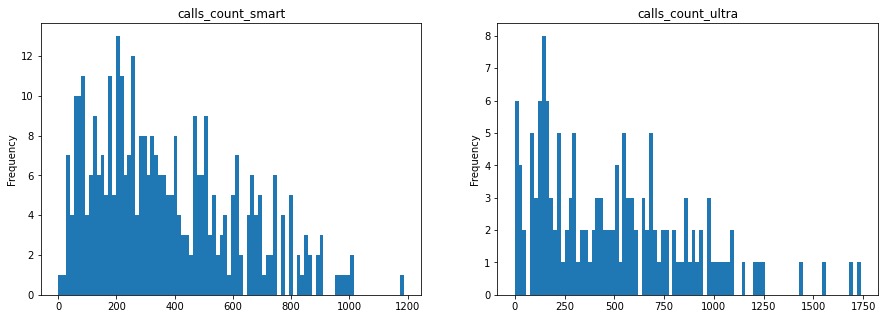

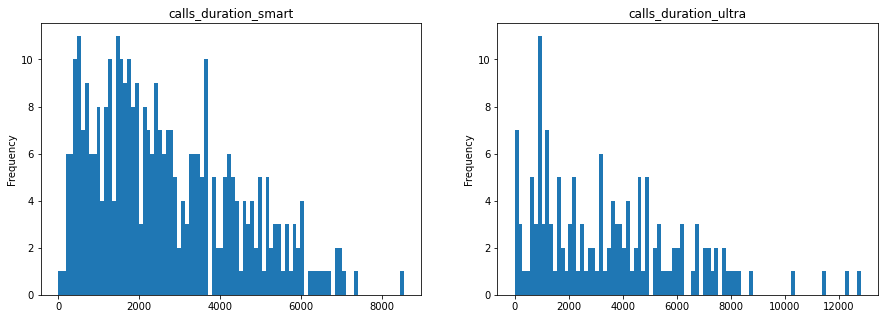

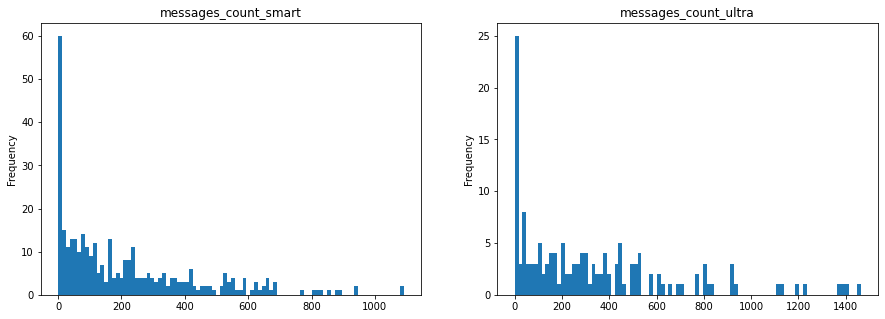

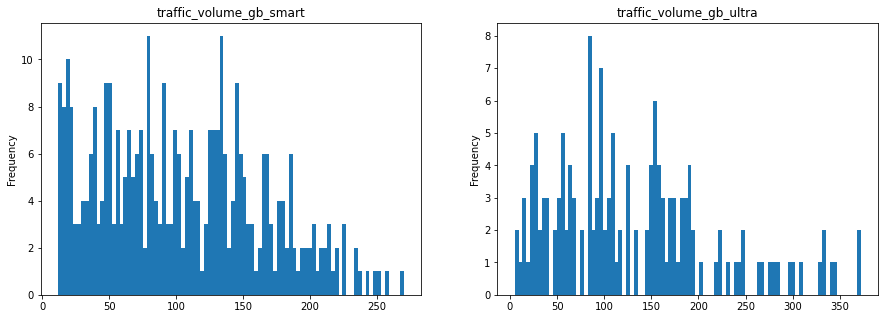

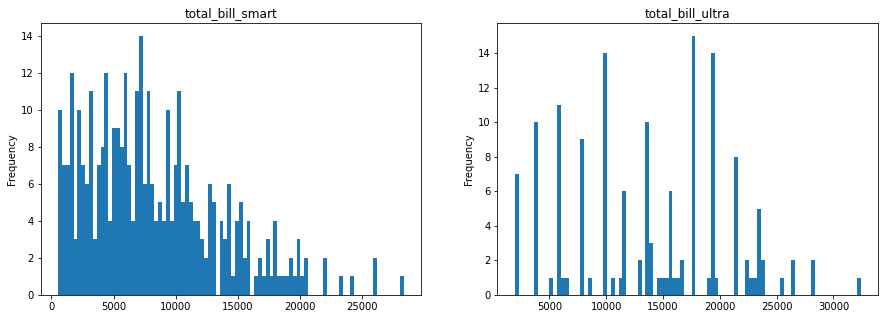

In [35]:
# гистограммы построим при помощи цикла рядом друг с другом, чтобы было проще сравнивать тарифы

for csfh_name_column in cmit_sum_for_hist.columns[2:]:
    fig, axs = plt.subplots(1,2)
    cmit_sum_for_hist[cmit_sum_for_hist['tariff']=='smart'][csfh_name_column].plot(bins=90, kind='hist', figsize=(15, 5), title=csfh_name_column+'_smart', ax=axs[0])
    cmit_sum_for_hist[cmit_sum_for_hist['tariff']=='ultra'][csfh_name_column].plot(bins=90, kind='hist', figsize=(15, 5), title=csfh_name_column+'_ultra', ax=axs[1])

В силу большей дисперсии ультра имеет более длинные хвосты чем смарт.

Количество звонков: Пик у смарт приходится на 200, у ультра - около 130.
Продолжительность звонков: У смарт наблюдается два основных пика около 400 и 1500 минут, у ультра один - около 1000. В основном люди тарифа смарт говорят не больше 6000 минут в год, в то время как клиенты ультра почти 8000 минут. Также видим, что у ультра есть небольшой пик на околонулевых значениях (0 - 250).
Количество сообщений: В обоих тарифах высока доля людей крайне мало использующих смс. При этом следует помнить, что ранее мы заменили 500 пропусков в датафрейме нулями и сейчас наблюдаем результаты этого действия. Но в любом случае все сейчас пользуются месенджерами.
Интернет-трафик: У обоих тарифов наблюдается четкая граница в районе 200-220 гб, после которой совсем мало значений. Пик у ультра в районе 80 гб, у смарт два пика - один в районе 70, другой около 140 гб.
Итоговый счет: Т.к. пользователи подключались в разное время года и не все оставались на одном тарифе до конца мы видим, что большая часть трат на связь находится до уровня минимальной годовой абонентской платы, которая для смарт составляет 6600, а для ультра 23400. У смарт второй пик находится в районе 7500, после чего идет плавное уменьшение числа людей перерасходовавших траифный план, т.е. большая часть людей хоть немного, но перерасходует тарифные лимиты. У ультра большинство пользователей тратит до 20000, после чего есть еще одна граница в районе 23000-24000, после чего небольшой хвост, т.е. пользователя тарифа ультра в основном укладываются в лимиты тарифного плана и не перерасходуют его.

## Проверка гипотез

**Первая гипотеза**

Первая гипотеза которую нужно проверить - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформулируем нулевую и альтернативную гипотезы:

    H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.
    H1 - средние выручки пользователей тарифов «Ультра» и «Смарт» различаются.
    
Чтобы проверить гипотезу о равенстве среднего применим метод scipy.stats.ttest_ind (array1, array2, equal_var), где equal_var - параметр, задающий считать ли равными дисперсии выборок. Передаётся как "equal_var = True" или "equal_var = False" (True — считать, False — не считать). Т.к. мы знаем, что дисперсии выборок по смарт и ультра различаются (3.436001e+07 и 9.886460e+07 соответственно), то equal_var зададим как False.

In [37]:
smart_ttest = data[data['tariff']=='smart']['total_bill']
ultra_ttest = data[data['tariff']=='ultra']['total_bill']

# уровень значимости зададим равным 5%
alpha = 0.5

results = st.ttest_ind(smart_ttest, ultra_ttest, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.224039400289816e-249
Отвергаем нулевую гипотезу


p-уровень значимости слишком мал, гораздо меньше определенного нами порогового значения в 5% => средняя выручка пользователей тарифов смарт и ульра значимо отличаются друг от друга.

**Вторая гипотеза**

Вторая гипотеза для проверки звучит так - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

    Н0 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
    Н1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    
Альтернативная гипотеза у нас двусторонняя, т.к. средняя выручка из Москвы может отличаться от других регионов как в большую так и в меньшую сторону.

Для проверки гипотезы воспользуемся методом scipy.stats.ttest_1samp (array, popmean), где в качестве массива данных будет выборка выручки по москвичам, а в качестве popmean (предполагаемого среднего, на равенство которому мы делаем тест) будет выступать среднее значение выручки пользователей из других регионов.

In [38]:
moscow_ttest = data[data['city']=='Москва']['total_bill']
popmean = data[data['city']!='Москва']['total_bill']

# уровень значимости 5%
alpha = 0.05

results = st.ttest_ind(moscow_ttest, popmean)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.521500152176397
Не получилось отвергнуть нулевую гипотезу


р-уровень значимости составил почти 39%, что значительно выше 5% => средняя выручка по Москве статистически значимо не отличается от средней выручки по другим регионам.

## Общий вывод:

Мы вывели из предоставленных нам таблиц все необходимые средние значения израсходованных минут, мегабайт и сообщений, а также прибыль по ним по каждому месяцу и посчитали по каждому из клиентов среднюю прибыль для компании. Далее мы разделили всех клиентов по тарифным группам и проверили правильность нашей гипотезы.

Оказалось, действительно, средняя прибыльность в двух тарифах отличается (пользователи тарифа ультра платят больше), в то время как средняя выручка по Москве статистически значимо не отличается от средней выручки по другим регионам.

Из-за проверки второй гипотизы выяснили, что рекламную компанию можно устроить по всей территории распространения сети.
А поведение клиентов в течение года отображенное на графиках дает представление, когда лучше проводить рекламную компанию. Соответственно, тариф ultra приносит больше выгоды, и стоило бы сконцетрироваться на нем.